### Imports 

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Silence tensorflow alerts
import tensorflow as tf

In [4]:
import sys
path_to_software_folder = sys.path[0][:-22] + 'software/'
sys.path.append(path_to_software_folder) # Add the software folder to path, note that outside of the "demo" folder you will need to manually set "path_to_software_folder"
from DoubleWell import DoubleWell
from ProcessingNets import *
from Network_Active import *
from FlowRES_MCMC_Active import *
from Plotting import *

# Define the model

In [5]:
start_point = [-1.0, 0]
duration = 1.6
traj_len = 32
D_t = 0.15
mu = 0.1
v = 1.0
D_r = 2.5
dt = duration/traj_len
tran_coeff = np.sqrt(2*D_t*dt)
rot_coeff = np.sqrt(2*D_r*dt)
act_coeff = v*dt
pot_coeff = mu*dt

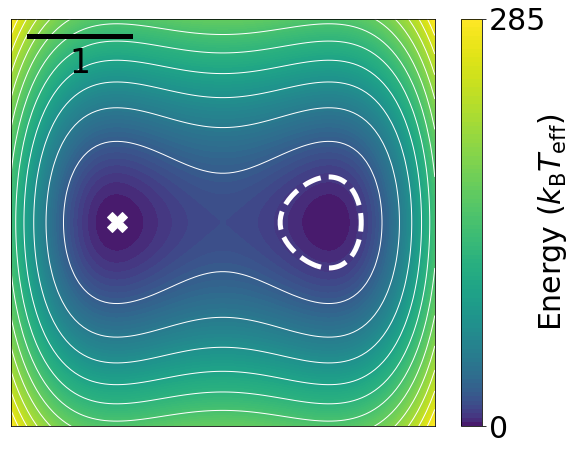

In [6]:
params = {'x_0' :  1.0,
          'k_x' :  2.0,
          'k_y' :  10.0,
          'k_BH' : 15,
          'target': 7.5}
Double_Well = DoubleWell(params=params)
Double_Well.plot_energy_surface_DW()

# Create a network

In [7]:
Affine_Wave_params = {'num_filters': 32,
                      'kernel_size': 3,
                      'num_dilated_conv_layers': 3}

Num_Layers = 2    # number of scales
FLOWS_per_LAYER = 5    # number of complete flow steps per flow
Pos_flows_per_Flow = 2    # number of position flow steps per complete flow step

Ang_flows_per_Flow = 0    # Leave this as 0
CCs = 1    # Just leave this as one
Pos_CC_per_Flow = 1    # Number of affine cross coupling layers per complete flow step
Ang_CC_per_Flow = 0    # Leave this as 0, this term lets positions affect angles

Net = CreateFlowNet(Num_Layers, FLOWS_per_LAYER,
                    Pos_flows_per_Flow, Ang_flows_per_Flow, 
                    CCs, Pos_CC_per_Flow, Ang_CC_per_Flow,
                    Affine_WaveNet=Wave_unit, Affine_WaveParams=Affine_Wave_params, 
                    potential_grad=Double_Well.batch_gradient,
                    start=start_point, tran_coeff=tran_coeff, rot_coeff=rot_coeff, act_coeff=act_coeff, pot_coeff=pot_coeff,
                    max_len=traj_len, dim=3)

... creating network
Network created.


# Explore Using FlowRES

In [ ]:
num_chains = 30000
num_iterations = 100

FlowRES_Active_DoubleWell = FlowRes_MCMC(Net, num_chains, Chain_Initialiser_Active, Double_Well)    # define the FlowRES framework for this system
FlowRES_Active_DoubleWell.Compile_ML_Model(batch_size=512, lr=0.00005)    # compile the network so that it is ready to train    

all_FlowRES_paths = FlowRES_Active_DoubleWell.Explore(iterations=num_iterations, return_hists=True, hist_bins=np.linspace(-2,2,200))[0]

Iteration 1 / 100


/home/cs-solomon.asghar/.local/lib/python3.7/site-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


    accepted 82.12666666666667% of non-local proposals
Train on 24576 samples
24576/24576 [==============================] - 42s 2ms/sample - loss: 9279.3934 - tf_op_layer_concat_76_loss: 9279.3916 - tf_op_layer_GatherV2_96_loss: 0.0000e+00

    network trained with non-local proposals
Iteration 2 / 100
    accepted 49.89% of non-local proposals
Train on 28672 samples
28672/28672 [==============================] - 22s 764us/sample - loss: 8266.0546 - tf_op_layer_concat_76_loss: 8266.0547 - tf_op_layer_GatherV2_96_loss: 0.0000e+00

    network trained with non-local proposals
Iteration 3 / 100
    accepted 42.346666666666664% of non-local proposals
Train on 29696 samples
29696/29696 [==============================] - 23s 768us/sample - loss: 7076.3272 - tf_op_layer_concat_76_loss: 7076.3267 - tf_op_layer_GatherV2_96_loss: 0.0000e+00

    network trained with non-local proposals
Iteration 4 / 100
    accepted 38.82666666666667% of non-local proposals
Train on 29696 samples
29696/29696 [=

# Compare FlowRES to Direct Integration

In [ ]:
# Load in Direct Integration data for comparison
Validation_histogram = np.load(sys.path[0] + '/Direct_Integration_Data/Validation_histogram.npy')    # load a histogram generated from 10000 direct integration paths
Direct_integration_histogram = np.load(sys.path[0] + '/Direct_Integration_Data/Direct_integration_histogram.npy')    # load a histogram generated from 50000 direct integration paths
Direct_Integration_JSD_vs_Proposals = np.load(sys.path[0] + '/Direct_Integration_Data/Direct_Integration_JSD_vs_Proposals.npy')    # load a JSD with validation ensemble against proposal number for direct integration

## Plot JSDs with Validation Ensemble

In [ ]:
bins = np.linspace(-2,2,200)
all_FlowRES_JSDs = np.zeros(np.shape(all_FlowRES_paths)[1])

for i, ensemble in enumerate(np.swapaxes(all_FlowRES_paths, 0,1)):    # plot a histogram for the FlowRES ensemble at each iteration and work out its JSD from the validation histogram
    clip_ensemble = clip_reac(ensemble, Double_Well)
    FlowRES_histogram = Hist2D(clip_ensemble, bins)
    all_FlowRES_JSDs[i] = JSD(FlowRES_histogram, Validation_histogram)
    
Num_Paths_Proposed_FlowRES = np.shape(all_FlowRES_paths)[0] * np.arange(np.shape(all_FlowRES_paths)[1])
FlowRES_JSD_vs_Proposals = np.stack([Num_Paths_Proposed_FlowRES, all_FlowRES_JSDs])

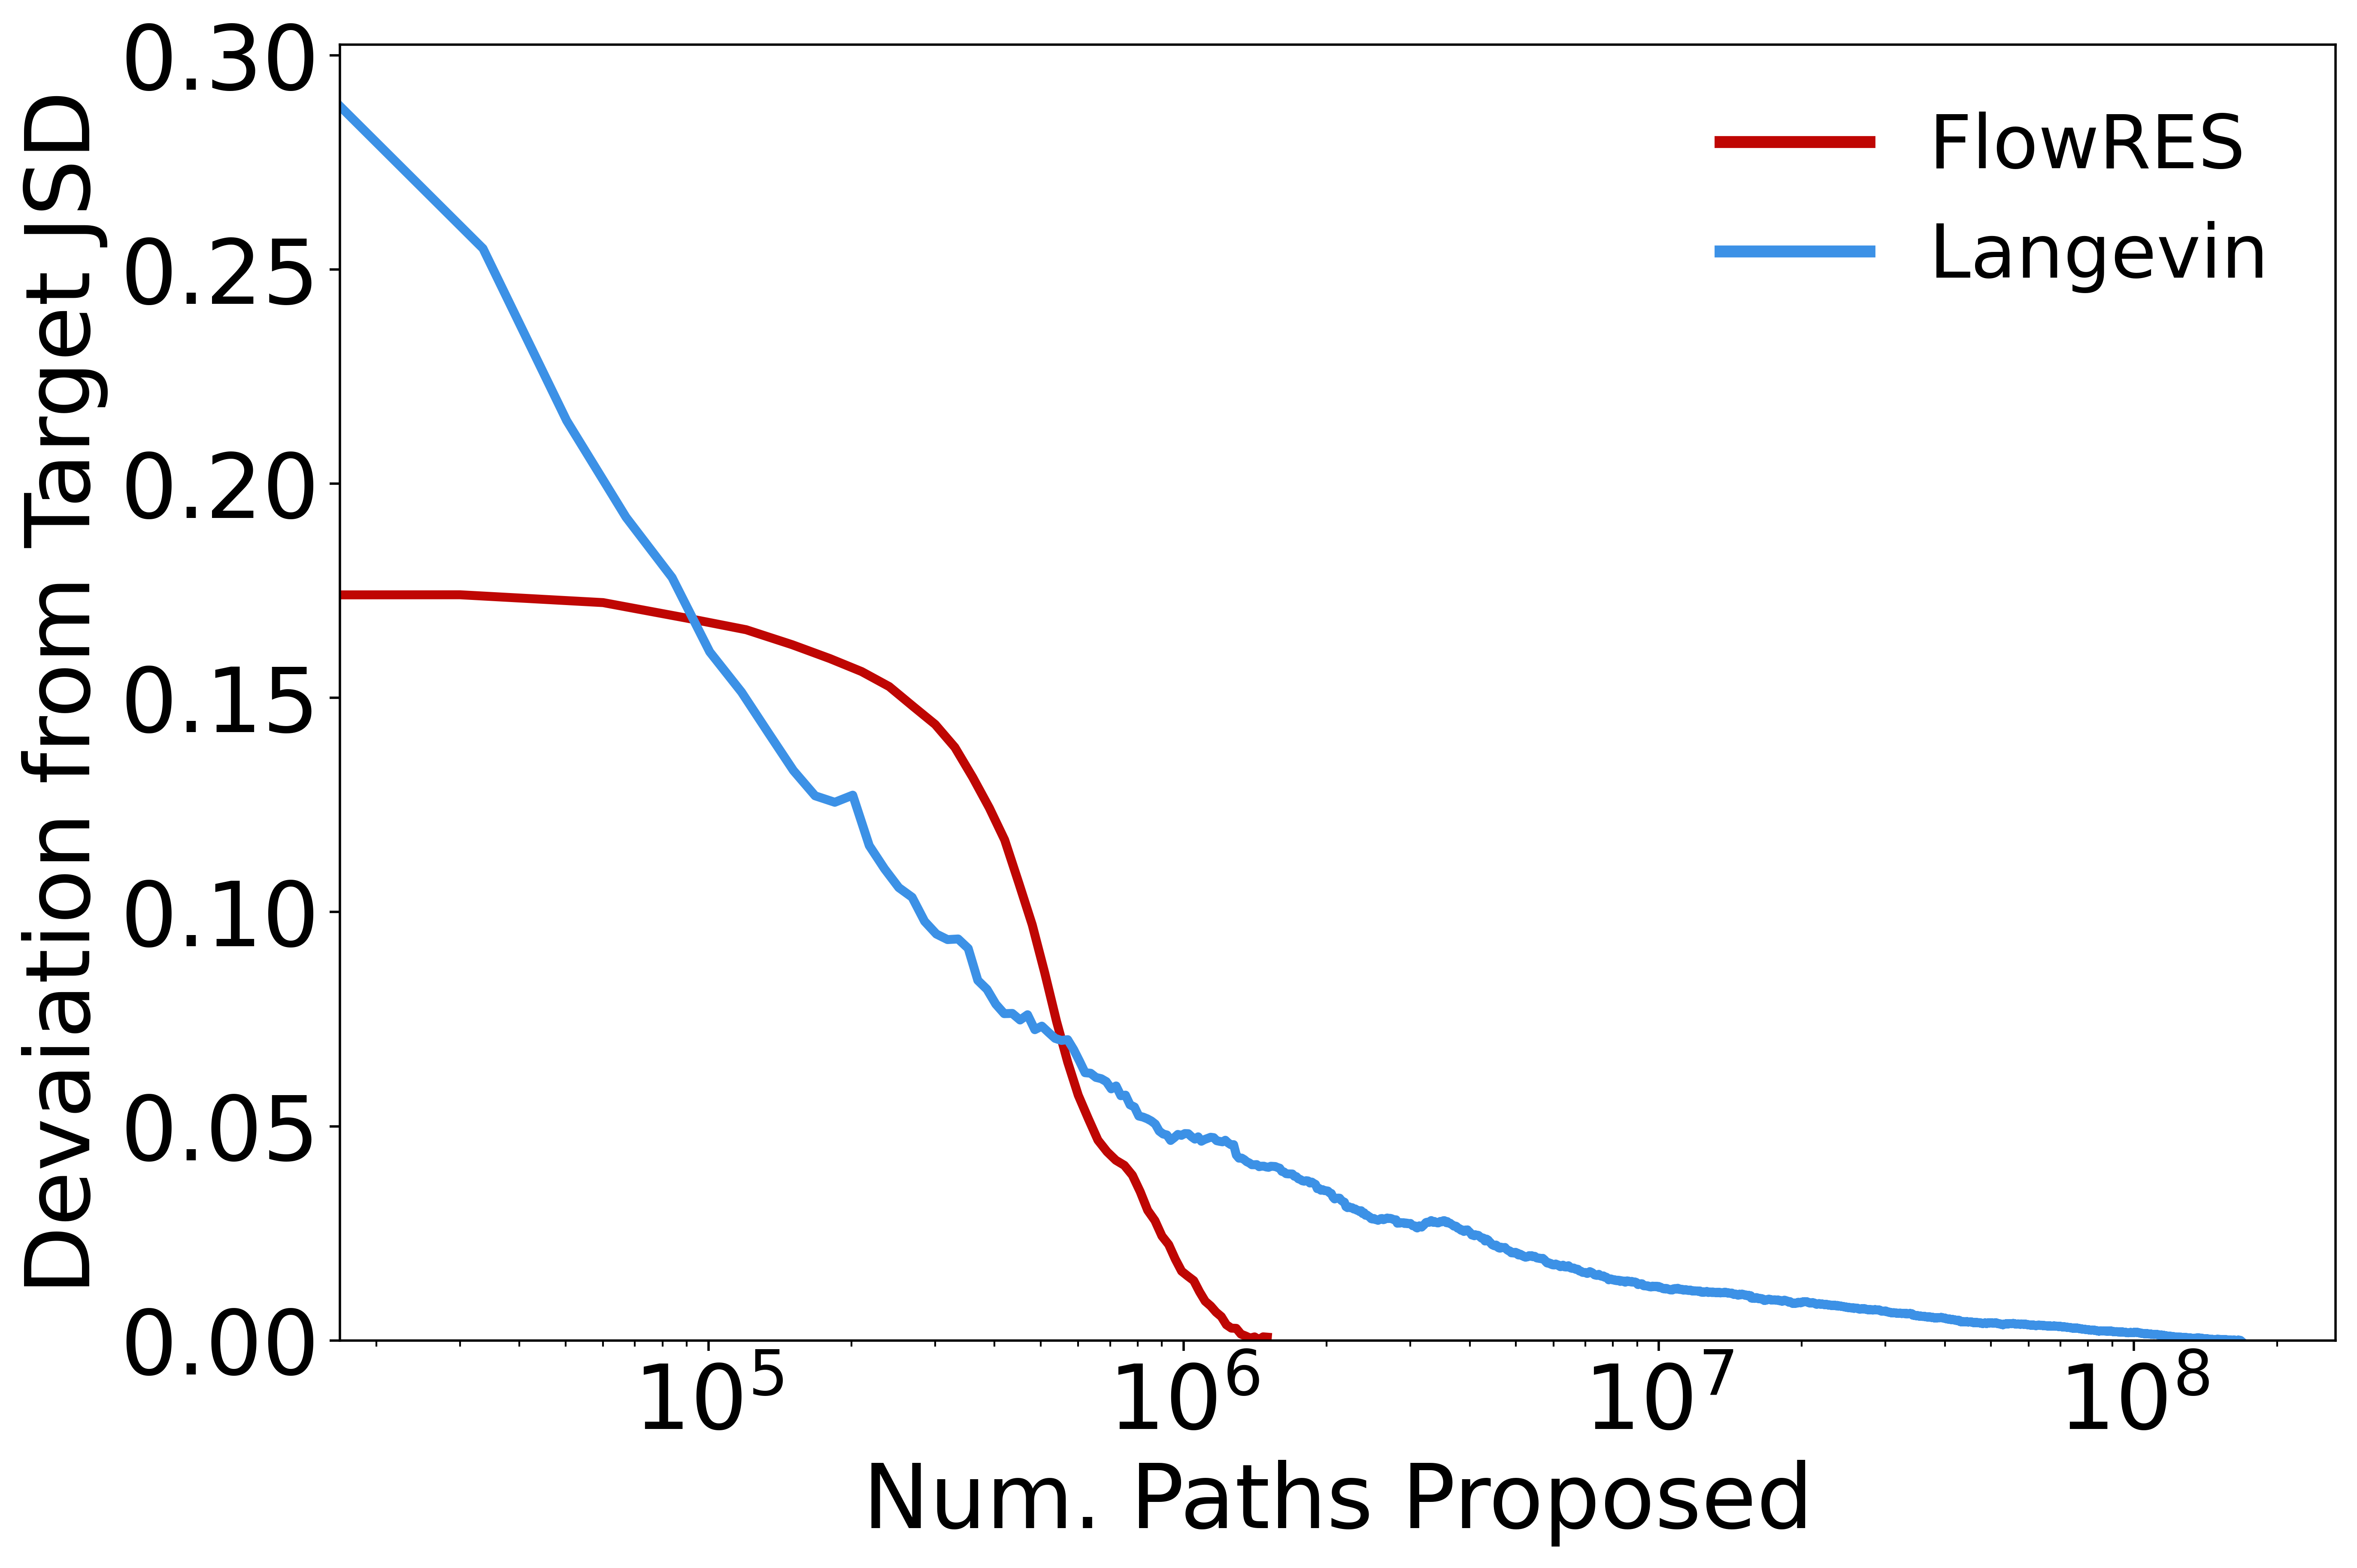

In [110]:
compare_JSDS(FlowRES_JSD_vs_Proposals, Direct_Integration_JSD_vs_Proposals)

## FlowRES and Direct Integration Histograms

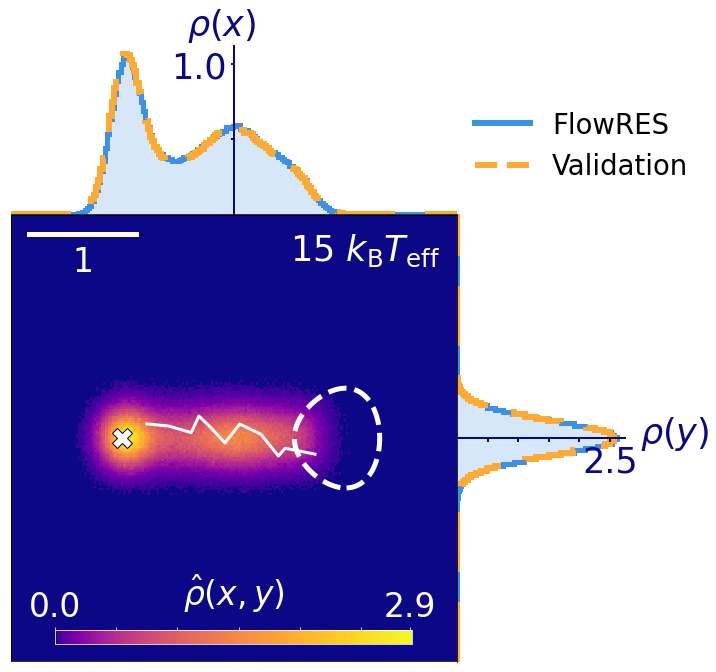

In [127]:
# pick a random path from FlowRES for visualisation
random_path = all_FlowRES_paths[:,-1][np.random.randint(len(all_FlowRES_paths))]
random_path_clipped = clip_reac(np.array([random_path]), Double_Well)[0].T
# plot histograms
Compare_Hists(FlowRES_histogram, Validation_histogram, bins, Double_Well,
              text=str(params['k_BH']) + r'$\ k_{\rm B} T_{\rm eff}$', path=random_path_clipped)

# Plotting backup

In [101]:
def compare_JSDS(FlowRES_JSD_vs_Proposals, Direct_Integration_JSD_vs_Proposals, plot_deviation_from_target=True):
    y_label = 'JSD with Validation Distribution'
    if plot_deviation_from_target:
        y_label = 'Devaiation from Target JSD'
        Target_JSD = Direct_Integration_JSD_vs_Proposals[1,-1]
        Direct_Integration_JSD_vs_Proposals[1] = Direct_Integration_JSD_vs_Proposals[1] - Target_JSD
        FlowRES_JSD_vs_Proposals[1] = FlowRES_JSD_vs_Proposals[1] - Target_JSD
    
    plt.rcParams['figure.figsize'] = 12,8
    plt.rcParams['font.size'] = 30
    plt.figure(dpi=500)

    red = '#3C91E6'
    blue = '#BF0603'

    lw_1 = 3
    lw_2 = 5
    plt.plot(*FlowRES_JSD_vs_Proposals, color=blue, linewidth=lw_1)
    plt.plot(*Direct_Integration_JSD_vs_Proposals, color=red, linewidth=lw_1)
    plt.xlabel('Num. Paths Proposed')
    plt.ylabel(y_label)
    plt.xscale('log')
    plt.xlim(Direct_Integration_JSD_vs_Proposals[0,0])
    plt.ylim(0)

    legend_elements = [Line2D([0], [0], color=blue, linewidth=4, label='FlowRES'),
                       Line2D([0], [0], color=red, linewidth=4, label='Langevin')]
    plt.legend(handles = legend_elements, ncol=1, fontsize=25, frameon=False)

    plt.show()

In [ ]:
def JSD(Hist, val_Hist):
    Counts_x = np.sum(Hist, axis=0)
    Counts_y = np.sum(Hist, axis=1)
    val_Counts_x = np.sum(val_Hist, axis=0)
    val_Counts_y = np.sum(Hist, axis=1)
    JS_x = scipy.spatial.distance.jensenshannon(Counts_x, val_Counts_x, axis=(0))
    JS_y = scipy.spatial.distance.jensenshannon(Counts_y, val_Counts_y, axis=(0))
    return (JS_x + JS_y)/2

In [11]:
plasma = matplotlib.colormaps['plasma']
plasma_new_colors = plasma(np.linspace(0,1,256)**0.5)
plasma_2 = ListedColormap(plasma_new_colors)

In [126]:
plasma = matplotlib.colormaps['plasma']
plasma_new_colors = plasma(np.linspace(0,1,256)**0.5)
plasma_2 = ListedColormap(plasma_new_colors)

height_ratios = [0.75,2]
width_ratios = [2,0.75]
figsize = 8*(2.75/2)
plt.rcParams['figure.figsize'] = figsize,figsize*1.033
plt.rcParams['font.size'] = 25
gs = gridspec.GridSpec(2, 2, height_ratios=height_ratios, width_ratios=width_ratios) 
gs.update(wspace=0.0, hspace=0.0)

def Get_Density(counts, bins):
    '''
    Convert a count to a density
    '''
    return counts / (sum(counts) * np.diff(bins))


def Hist2D(Trajs, bins):
    Trajs = np.concatenate(Trajs)
    Trajs_x = Trajs[:,0].flatten()
    Trajs_y = Trajs[:,1].flatten()
    return np.histogram2d(Trajs_x, Trajs_y, bins, density=True)[0].T


def clip_reac(Trajs, potential, include_last=True, return_lens=False):
    '''
    Return a mask where only valid trajs are True
    '''
    energies = potential.energy(Trajs, input_mode='Batch')
    energy_mask = energies < potential.params['target']
    right_mask = Trajs[:,:,0] > 0
    r_e_mask = np.logical_and(energy_mask,right_mask)
    not_r_e_mask = np.logical_not(r_e_mask)
    unreactive_mask = np.all(not_r_e_mask, axis=1)
    reactive_mask = np.logical_not(unreactive_mask)
    
    reac_Trajs = Trajs[reactive_mask]
    arg_reactive = np.argwhere(r_e_mask[reactive_mask])
    ind_of_first_reac = np.unique(arg_reactive[:,0], return_index=True)[1]
    timestep_of_first_reac = arg_reactive[ind_of_first_reac,1]

    clipped_Trajs = []
    if include_last is True:
        timestep_of_first_reac += 1
    for traj, first in zip(reac_Trajs,timestep_of_first_reac):
        clipped_Trajs.append(traj[:first])
    
    if return_lens is False:
        return clipped_Trajs
    else:
        return clipped_Trajs, timestep_of_first_reac+1

    
def Compare_Hists(NF_Hist_2D, Target_Hist_2D, bins, potential, text, path,  Add_Scale_Bar=True, cmap=plasma_2):
    fsz = 33
    
    plt.rcParams['figure.figsize'] = figsize, figsize*1.03
    barrier_height = int(potential.params['k_BH'])
    main, ax1 = Plot_pc_Hist(NF_Hist_2D,  bins, c1='#3C91E6', lw=5, plot_target_well=True, potential=potential,
                 barrier_height=barrier_height, Add_Scale_Bar=Add_Scale_Bar, cmap=cmap, text=text)
    ax1.plot(*path, color='white', linewidth=3)
    Plot_pc_Hist(Target_Hist_2D, bins, plot_xy=False, c1='#FDAB33', linestyle= (0, (10,5)), alph=0.0, lw=6, Add_Scale_Bar=False, zorder=1, cmap=cmap, text=text)
    cbaxes = inset_axes(ax1,
                        width="80%",  # width = 10% of parent_bbox width
                        height="3.0%",  # height : 50%
                        loc='lower center')
    cb = plt.colorbar(main, cax=cbaxes, ticklocation='top', 
                      label=r'$\hat{\rho}(x,y)$', orientation="horizontal")
    cbarticks = list(np.arange(*cbaxes.get_xlim(), 0.5))
    highest_p1 = np.floor((cbaxes.get_xlim()[1])*10)/10
    if not cbarticks[-1] >= highest_p1:
        cbarticks += [highest_p1]
    cbartick_labels = [str(cbarticks[0])] + ['' for i in range(len(cbarticks)-2)] + [str(cbarticks[-1])]
    cb.set_ticks(cbarticks, labels=cbartick_labels, fontsize=fsz)
    cbaxes.tick_params(axis='both', colors='white')
    cb.outline.set_edgecolor('white')
    cb.set_label(r'$\hat{\rho}(x,y)$', color='white', labelpad=-15, fontsize=fsz)
    plt.show()
    
    
def Plot_pc_Hist(Hist_2D, bins, gs=gs, figsize=15, c1='blue', alph = 0.21, plot_xy=True, linestyle='solid', lw=5.0,
                 plot_target_well=False, potential=None, barrier_height=None, Add_Scale_Bar=True, zorder=1, cmap=None, text=None):
    fsz = 33
    plt.rcParams['font.size'] = 35
    ypad = 20
    spine_color = '#0C0786'
    
    Counts_x = np.sum(Hist_2D, axis=0)
    Counts_y = np.sum(Hist_2D, axis=1)
    
    Counts_x = Get_Density(Counts_x, bins)
    Counts_y = Get_Density(Counts_y, bins)
    
    ax0 = plt.subplot(gs[0,0])
    ax1 = plt.subplot(gs[1,0])
    ax2 = plt.subplot(gs[1,1])

    # x 
    ax0.stairs(Counts_x, bins, color=c1, linewidth=lw, linestyle=linestyle, zorder=zorder)
    ax0.stairs(Counts_x, bins, color=c1, fill=True, alpha=alph, zorder=zorder)
    ax0.axes.get_xaxis().set_visible(False)
    ax0.set_xlim(bins[0],bins[-1])
    ax0.yaxis.label.set_color(spine_color)
    ax0.tick_params(axis='y', colors=spine_color)
    ax0.set_ylabel(r'$\rho(x)$', rotation=0, labelpad=-50, y=1.01)
    yticks = list(np.arange(*ax0.get_ylim(), 0.5)[1:])
    ytick_labels = ['' for i in range(len(yticks[:-1]))] + yticks[-1:]
    ax0.yaxis.set_ticks(yticks, labels=ytick_labels)
    
    # Move left y-axis and bottom x-axis to centre, passing through (0,0)
    ax0.spines['left'].set_position('center')
    # Eliminate upper and right axes
    ax0.spines['right'].set_color('none')
    ax0.spines['top'].set_color('none')
    ax0.spines['left'].set_linewidth(2.0)
    ax0.spines['left'].set_color(spine_color)
    ax0.yaxis.set_tick_params(width=2.0)
        
    # y 
    ax2.stairs(Counts_y, bins, color=c1, linewidth=lw, orientation='horizontal',  linestyle=linestyle, zorder=zorder)
    ax2.stairs(Counts_y, bins, color=c1, fill=True, alpha=alph, orientation='horizontal', zorder=zorder)
    ax2.axes.get_yaxis().set_visible(False)
    ax2.set_ylim(bins[0],bins[-1])
    ax2.xaxis.label.set_color(spine_color)
    ax2.tick_params(axis='x', colors=spine_color)
    
    ax2.set_xlabel(r'$\rho(y)$', labelpad=-65, x=1.3)
    ax2.xaxis.set_ticks([1])
    
    # Move left y-axis and bottom x-axis to centre, passing through (0,0)
    ax2.spines['bottom'].set_position('center')
    # Eliminate upper and right axes
    ax2.spines['right'].set_color('none')
    ax2.spines['top'].set_color('none')
    ax2.spines['bottom'].set_linewidth(2.0)
    ax2.spines['bottom'].set_color(spine_color)
    ax2.xaxis.set_tick_params(width=2.0)
    xticks = list(np.arange(*ax2.get_xlim(), 0.5)[1:])
    xtick_labels = ['' for i in range(len(xticks[:-1]))] + xticks[-1:]
    ax2.xaxis.set_ticks(xticks, labels=xtick_labels)
    
    if plot_xy is True:
        # x y
        main = ax1.imshow(Hist_2D, interpolation='nearest', origin='lower',
                   extent=[bins[0], bins[-1], bins[0], bins[-1]], cmap=cmap)
        ax1.set_xticks([])
        ax1.set_yticks([])
        
        if plot_target_well is True:
            x_lim=1.75
            alt_x_1s = np.linspace(0,x_lim, 100)
            x_2s = np.linspace(-x_lim,x_lim, 100)
            alt_X1grid, alt_X2grid = np.meshgrid(alt_x_1s, x_2s) 
            alt_Xs = np.vstack([alt_X1grid.flatten(), alt_X2grid.flatten()]).T
            alt_energies = potential.energy(alt_Xs)
            alt_energies = alt_energies.reshape((100,100))
            ax1.contour(alt_X1grid, alt_X2grid, alt_energies, levels=[potential.params['target']], colors='white', linewidths=5, linestyles='--')
            ax1.plot(-1,0, marker='X', markerfacecolor='white', markeredgecolor='black', linewidth=1, markersize=20, zorder=100)
                
        # Add scale bar #
        if Add_Scale_Bar is True:
            rect = patches.Rectangle((-1.85, 1.80), 1, 0.05, linewidth=1, edgecolor='None', facecolor='white')
            ax1.add_patch(rect)      
            ax1.text(-1.35, 1.725, "1", color='white', fontsize=fsz,
                     horizontalalignment='center', verticalalignment='top')
        
        ax1.text(1.85, 1.85, text, color='white',
                 horizontalalignment='right', verticalalignment='top')
        
        legend_elements = [Line2D([0], [0], color='#3C91E6', linewidth=6, label='FlowRES'),
                           Line2D([0], [0], color='#FDAB33', linewidth=6, linestyle='--', label='Validation')]
        plt.legend(loc=(0.04,1.05), handles = legend_elements, ncol=1, fontsize=27.5, frameon=False)
        
        return main, ax1